Задача: Оценить значение $\exp{(-7)}$ с помощью ряда

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import factorial


def expForwardSum(x: float, N: int) -> float:
    result = 0.0
    for k in range(N + 1):
        term = pow(x, k) / factorial(k)
        result += term
    return result

def expBackwardSum(x: float, N: int) -> float:
    result = 0.0
    for k in range(N, -1, -1):
        term = pow(x, k) / factorial(k)
        result += term
    return result

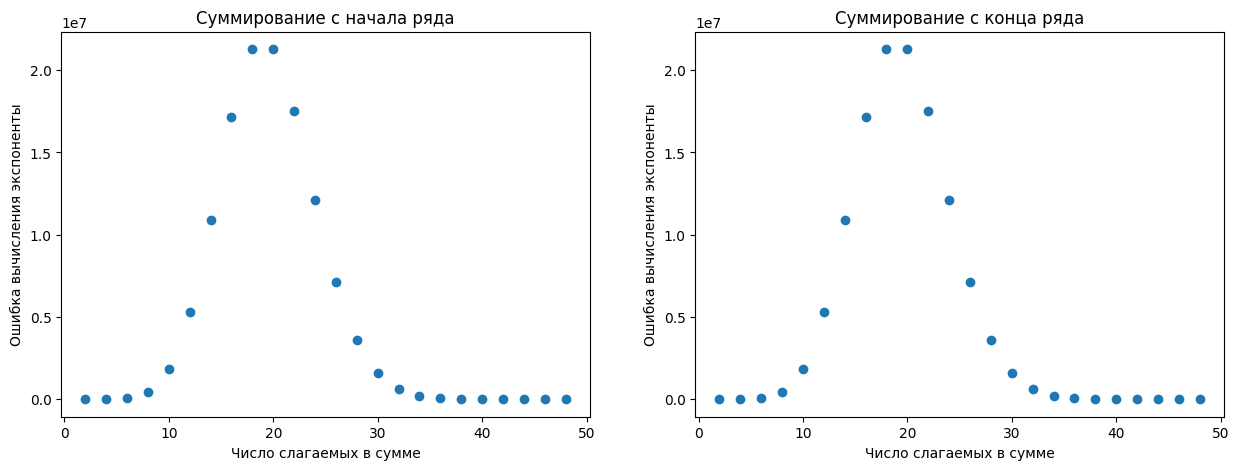

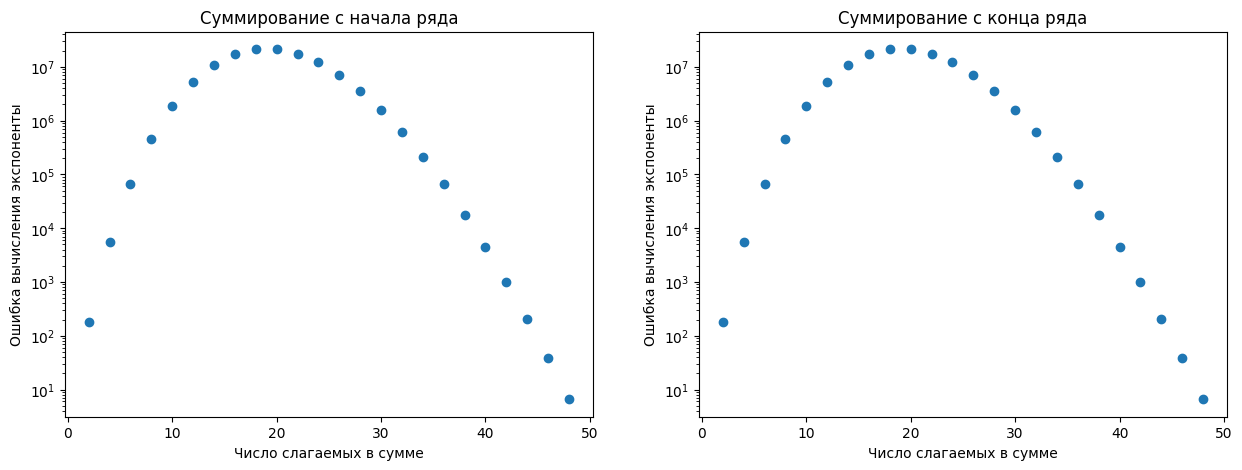

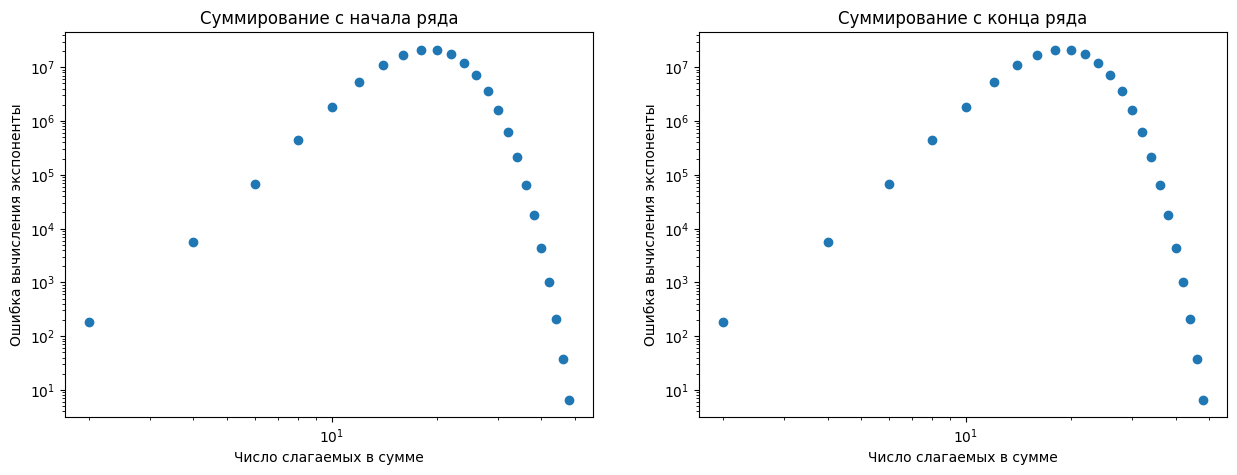

In [2]:
x = -20
exp_x = np.exp(x)
Ns = [*range(2, 50, 2)]
forwErrors = []
backErrors = []

for N in Ns:
    forwExp = expForwardSum(x, N)
    backExp = expBackwardSum(x, N)
    forwErrors.append(abs(exp_x - forwExp))
    backErrors.append(abs(exp_x - backExp))


fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(Ns, forwErrors)
axes[0].set_xlabel("Число слагаемых в сумме")
axes[0].set_ylabel("Ошибка вычисления экспоненты")
axes[0].set_title("Суммирование с начала ряда")

axes[1].scatter(Ns, backErrors)
axes[1].set_xlabel("Число слагаемых в сумме")
axes[1].set_ylabel("Ошибка вычисления экспоненты")
axes[1].set_title("Суммирование с конца ряда")
plt.savefig(("Exp_lin.png"), dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(Ns, forwErrors)
axes[0].set_xlabel("Число слагаемых в сумме")
axes[0].set_ylabel("Ошибка вычисления экспоненты")
axes[0].set_title("Суммирование с начала ряда")
axes[0].set_yscale('log')

axes[1].scatter(Ns, backErrors)
axes[1].set_xlabel("Число слагаемых в сумме")
axes[1].set_ylabel("Ошибка вычисления экспоненты")
axes[1].set_title("Суммирование с конца ряда")
axes[1].set_yscale('log')
plt.savefig(("Exp_semilog.png"), dpi=300, bbox_inches='tight')
plt.show()


fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(Ns, forwErrors)
axes[0].set_xlabel("Число слагаемых в сумме")
axes[0].set_ylabel("Ошибка вычисления экспоненты")
axes[0].set_title("Суммирование с начала ряда")
axes[0].set_yscale('log')
axes[0].set_xscale('log')

axes[1].scatter(Ns, backErrors)
axes[1].set_xlabel("Число слагаемых в сумме")
axes[1].set_ylabel("Ошибка вычисления экспоненты")
axes[1].set_title("Суммирование с конца ряда")
axes[1].set_yscale('log')
axes[1].set_xscale('log')
plt.savefig(("Exp_log.png"), dpi=300, bbox_inches='tight')
plt.show()

In [5]:
from scipy.linalg import inv as Inv
from scipy.linalg import eig
from scipy.sparse import diags
import time

maxIterNumber = 100000

def arnoldi_iteration(A, b, n: int):
    eps = 1e-12
    h = np.zeros((n + 1, n))
    Q = np.zeros((A.shape[0], n + 1))
    # Normalize the input vector
    Q[:,0] = b / np.linalg.norm(b, 2)   # Use it as the first Krylov vector
    for k in range(1, n + 1):
        v = np.dot(A, Q[:, k - 1])  # Generate a new candidate vector
        for j in range(k):  # Subtract the projections on previous vectors
            h[j, k - 1] = np.dot(Q[:,j].T, v)
            v = v - h[j, k - 1] * Q[:,j]
        h[k, k - 1] = np.linalg.norm(v, 2)
        if h[k, k - 1] > eps:  # Add the produced vector to the list, unless
            Q[:,k] = v / h[k, k - 1]
        else:  # If that happens, stop iterating.
            return Q, h
    return Q, h


def matrixExponent(matr, isDiagonal=False, isTridiagonal=False):
    n = matr.shape[0]
    first_term = np.diag(np.ones(n)) + matr / 2
    second_term = np.diag(np.ones(n)) - matr / 2
    second_term = Inv(second_term)
    return first_term @ second_term


# calculate exp(A + B); where A is more simple
def expOfSumMatrix(A, B):
    return matrixExponent(A / 2) @ matrixExponent(B) @ matrixExponent(A / 2)

    
def getPotentialValue(x: np.double, v_0: np.double) -> np.double:
    return (-1) * v_0 * np.exp(-1 * (x * x), dtype=np.double)


def makeHamiltonian(n: int, R: np.double, v_0: np.double) -> np.ndarray:
    delta = 2*R / (n-1)
    H0_diagonal = np.zeros(n, dtype=np.double)
    V_diagonal = np.zeros(n, dtype=np.double)
    H0_subDiagonal = np.ones(n-1, dtype=np.double) * (-1) / (delta * delta)
    
    xs = np.linspace(-R, R, n, dtype=np.double)
    
    for i in range(n):
        H0_diagonal[i] = 2 / (delta * delta)
        V_diagonal[i] = getPotentialValue(xs[i], v_0)

    # return diags([diagonal, subDiagonal, subDiagonal], [0, -1, 1])  
    return (H0_diagonal, H0_subDiagonal, V_diagonal)

# Прямые итерации с остановкой по оценке невязки
def estimateOfMax(matrix, acc):
    n = matrix.shape[0]
    residueValue = 100
    currentVector = np.random.normal(loc=0.0, scale=0.2, size=n)
    currentValue = np.linalg.norm(currentVector)

    currentVector = currentVector / currentValue


    iterNumber = 0
    while residueValue > acc:
        prevValue = currentValue
        currentVector = matrix @ currentVector
        currentValue = np.linalg.norm(currentVector)
        currentVector = currentVector / currentValue

        residueVector = matrix @ currentVector - currentValue * currentVector
        residueValue = np.linalg.norm(residueVector)

        iterNumber += 1
        if iterNumber > maxIterNumber:
            print("Calculation exceeds {} iterations!".format(maxIterNumber))
            break
    return currentValue, currentVector


def calcEigExp(A, B, tau_abs):
    tau = tau_abs * (-1)
    E = expOfSumMatrix(A * tau, B * tau)
    (eigValues, eigVectors) = eig(E)
    eigValues = np.log(eigValues) / tau
    # return sorted(eigValues.real)[0], eigVectors[:,0]
    idx = np.argmin(eigValues.real)
    return eigValues.real[idx], eigVectors[:,idx]


def calcEigExpWithIterations(A, B, tau_abs, acc):
    tau = tau_abs * (-1)
    E = expOfSumMatrix(A * tau, B * tau)
    (eigValue, eigVector) = estimateOfMax(E, acc)
    eigValue = np.log(eigValue) / tau
    return eigValue, eigVector

base value is -3.1404009040
-14.003988137410794
-4.981432100415814
-3.140541363101965
-3.140402308501558
-3.140400918026918
-3.140400905226406
-3.1404009102685184
-3.1404008635864527
-3.140401118643925
-3.140397232834295
-3.1404007941211476
-3.1402652929016366


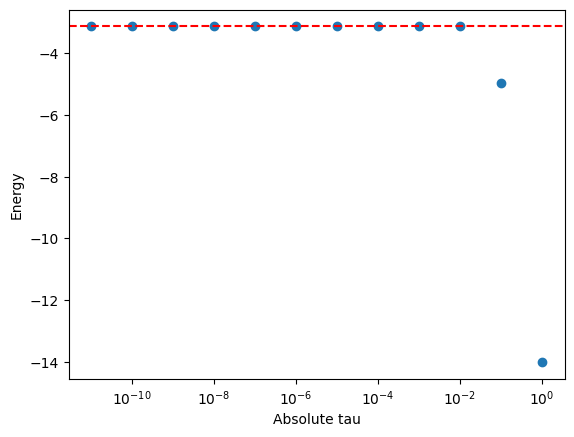

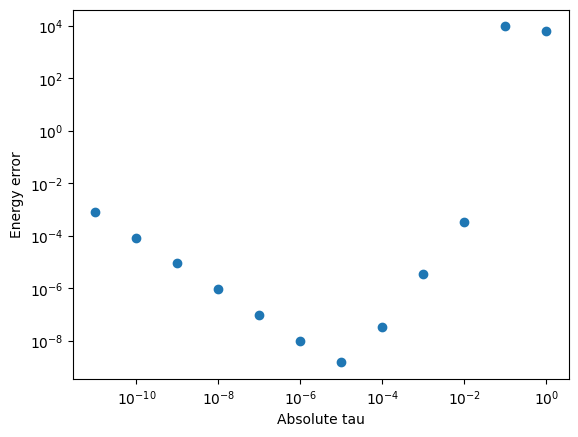

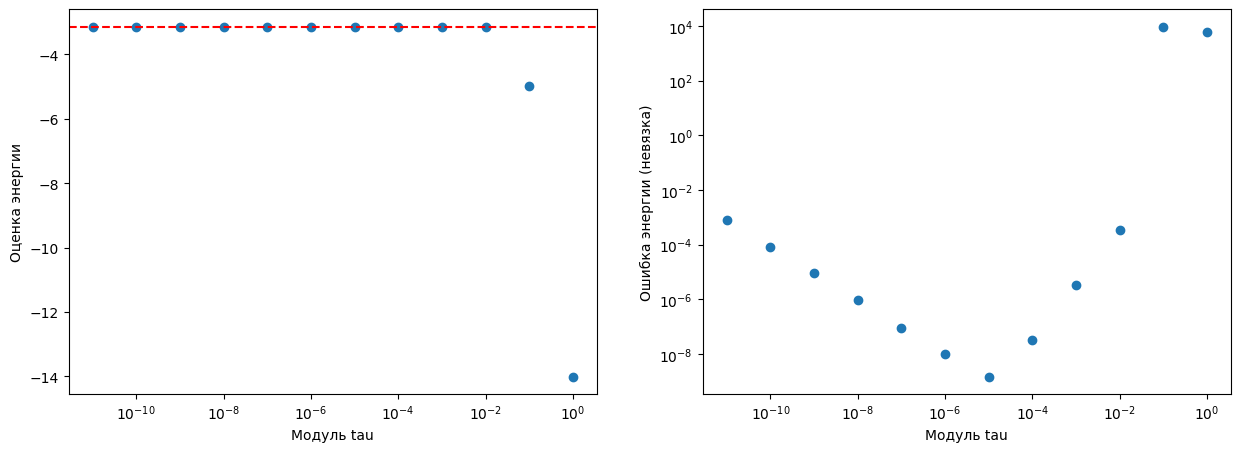

In [30]:
numberOfPoints = 1000 #[100, 20, 30,  50, 70, 100, 150,]# 200, 300, 500, 700, 1000, 1200, 1500, 1750, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000,]
boxBorder = 10
potential = 5

taus = np.power(0.1, [*range(12)], dtype=np.float32)
# print(taus)
energies = []
enErrors = []


H0_diag, H0_subdiag, V_diag = makeHamiltonian(numberOfPoints, boxBorder, potential)
H = diags([H0_diag, H0_subdiag, H0_subdiag], [0, 1, -1], dtype=np.double).toarray()
V = diags([V_diag], [0], dtype=np.double).toarray()
B = H + V
(eigValues, eigVectors) = eig(B)
base_value = sorted(eigValues.real)[0]
print("base value is {:.10f}".format(base_value))

# taus = [1e-2, 1e-3, 1e-4]
for t in taus:
    # e_value, e_vec = calcEigExpWithIterations(H, V, t, 1e-4)
    e_value, e_vec = calcEigExp(V, H, t)
    # residueValue = abs(e_value - base_value)
    residueValue = np.linalg.norm((H + V) @ e_vec - e_value * e_vec)    # Оценка невязки
    energies.append(e_value)
    enErrors.append(residueValue)
    print(e_value)

plt.scatter(taus, energies)
plt.xlabel("Absolute tau")
plt.ylabel("Energy")
plt.xscale('log')
plt.axhline(y=base_value, color='r', linestyle='dashed')
plt.show()

plt.scatter(taus, enErrors)
plt.xlabel("Absolute tau")
plt.ylabel("Energy error")
plt.xscale('log')
plt.yscale('log')
plt.show()

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(taus, energies)
axes[0].set_xlabel("Модуль tau")
axes[0].set_ylabel("Оценка энергии")
axes[0].set_xscale('log')
axes[0].axhline(y=base_value, color='r', linestyle='dashed')
axes[1].scatter(taus, enErrors)
axes[1].set_xlabel("Модуль tau")
axes[1].set_ylabel("Ошибка энергии (невязка)")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
plt.savefig(("En_Taus_scipy.png"), dpi=300, bbox_inches='tight')
plt.show()

base value is -3.1404009040
-4.938403522093316
9730.74966966814
-3.1410314218248505
0.009615468086021907
-3.1371339910870004
0.09978131713391374
-2.7600811423294456
0.9998074817713635
10.295215501838832
10.001234017509566
74.67997942531811
99.99098636211855
685.1056197511866
1000.0138568747064


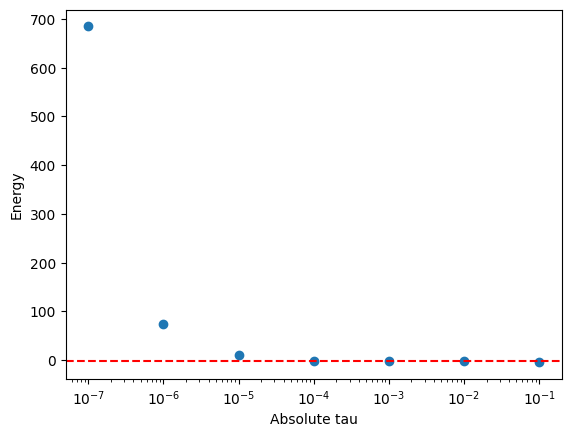

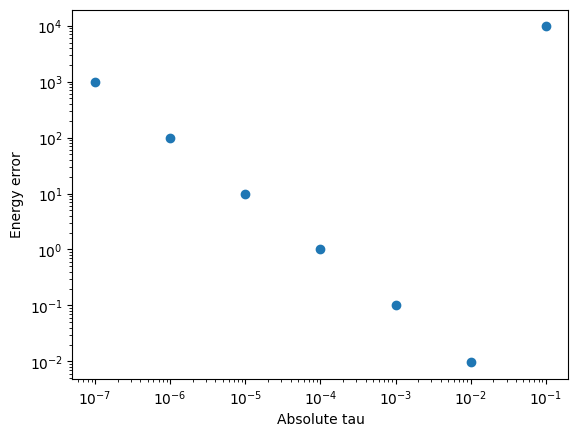

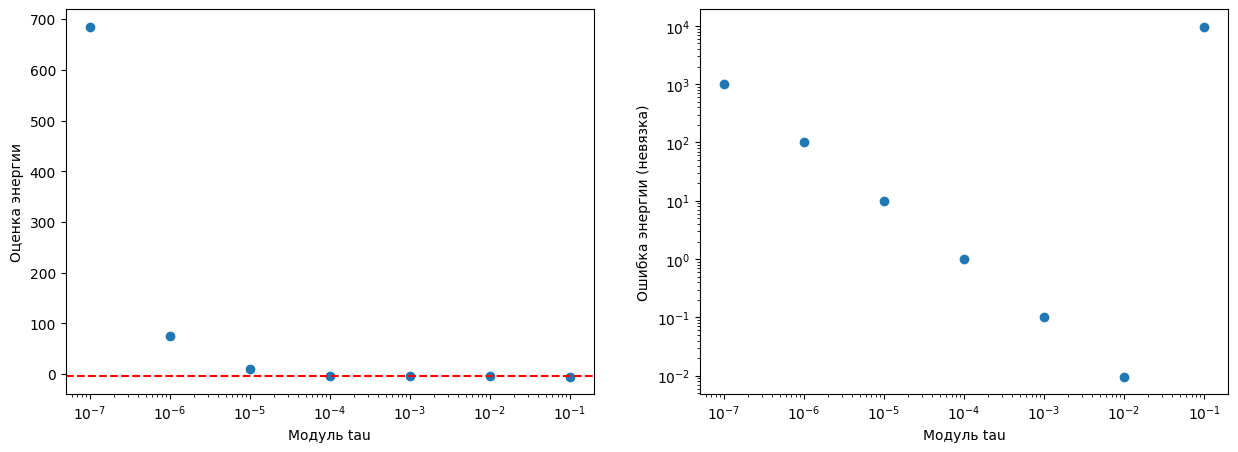

In [13]:
numberOfPoints = 1000 #[100, 20, 30,  50, 70, 100, 150,]# 200, 300, 500, 700, 1000, 1200, 1500, 1750, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000,]
boxBorder = 10
potential = 5

# taus = np.power(0.1, [*range(12)], dtype=np.float32)
# print(taus)
energies = []
enErrors = []


H0_diag, H0_subdiag, V_diag = makeHamiltonian(numberOfPoints, boxBorder, potential)
H = diags([H0_diag, H0_subdiag, H0_subdiag], [0, 1, -1], dtype=np.double).toarray()
V = diags([V_diag], [0], dtype=np.double).toarray()
B = H + V
(eigValues, eigVectors) = eig(B)
base_value = sorted(eigValues.real)[0]
print("base value is {:.10f}".format(base_value))

# taus = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
taus = np.power(0.1, [*range(1, 8)], dtype=np.float32)
for t in taus:
    e_value, e_vec = calcEigExpWithIterations(H, V, t, 1e-4)
    # e_value, e_vec = calcEigExp(H, V, t)
    # residueValue = abs(e_value - base_value)
    residueValue = np.linalg.norm((H + V) @ e_vec - e_value * e_vec)    # Оценка невязки
    
    energies.append(e_value)
    enErrors.append(residueValue)
    print(e_value)
    print(residueValue)

plt.scatter(taus, energies)
plt.xlabel("Absolute tau")
plt.ylabel("Energy")
plt.xscale('log')
plt.axhline(y=base_value, color='r', linestyle='dashed')
plt.show()

plt.scatter(taus, enErrors)
plt.xlabel("Absolute tau")
plt.ylabel("Energy error")
plt.xscale('log')
plt.yscale('log')
plt.show()

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(taus, energies)
axes[0].set_xlabel("Модуль tau")
axes[0].set_ylabel("Оценка энергии")
axes[0].set_xscale('log')
axes[0].axhline(y=base_value, color='r', linestyle='dashed')
axes[1].scatter(taus, enErrors)
axes[1].set_xlabel("Модуль tau")
axes[1].set_ylabel("Ошибка энергии (невязка)")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
plt.savefig(("En_Taus_Iter.png"), dpi=300, bbox_inches='tight')
plt.show()

In [34]:
numberOfPoints = [100, 200, 300, 500, 700, 1000, 1200, 1500, 1750, 2000,]# 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000,]
boxBorder = 10
potential = 5
hs = []
for n in numberOfPoints:
    hs.append(2 * boxBorder / n)

tau = 1e-5
# print(taus)
energiesN = []
enErrorsN = []
timeConsumed = []

for nPoint in numberOfPoints:
    start_time = time.time()
    H0_diag, H0_subdiag, V_diag = makeHamiltonian(nPoint, boxBorder, potential)
    H = diags([H0_diag, H0_subdiag, H0_subdiag], [0, 1, -1], dtype=np.double).toarray()
    V = diags([V_diag], [0], dtype=np.double).toarray()

    e_value, e_vec = calcEigExp(V, H, tau)

    res_time = time.time() - start_time
    timeConsumed.append(res_time) 

    residueValue = abs(e_value - base_value)
    energies.append(e_value)
    enErrors.append(residueValue)
    print("For {} dots, E = {:.10f}".format(nPoint, e_value))


For 100 dots, E = -3.1472086054
For 200 dots, E = -3.1420242713
For 300 dots, E = -3.1410818153
For 500 dots, E = -3.1406023130
For 700 dots, E = -3.1404706999
For 1000 dots, E = -3.1404009041
For 1200 dots, E = -3.1403804350
For 1500 dots, E = -3.1403636970
For 1750 dots, E = -3.1403558053
For 2000 dots, E = -3.1403506853


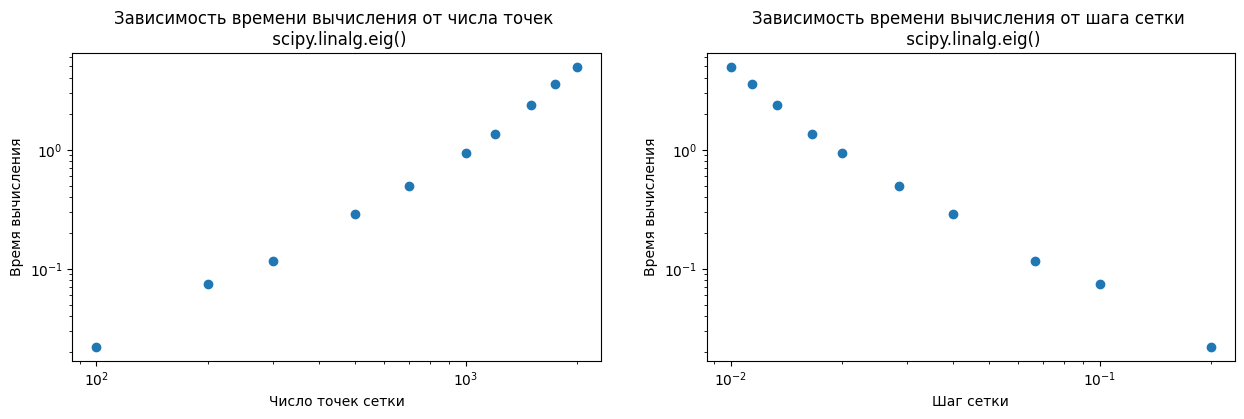

1.9725836605137943


In [36]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))
axes[0].scatter(numberOfPoints, timeConsumed)
axes[0].set_xlabel("Число точек сетки")
axes[0].set_ylabel("Время вычисления")
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title("Зависимость времени вычисления от числа точек \n scipy.linalg.eig()")
axes[1].scatter(hs, timeConsumed)
axes[1].set_xlabel("Шаг сетки")
axes[1].set_ylabel("Время вычисления")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title("Зависимость времени вычисления от шага сетки \n scipy.linalg.eig()")
plt.savefig(("Time_Taus_Eig.png"), dpi=300, bbox_inches='tight')
plt.show()

timesLog = np.log10(timeConsumed)
dotsLog = np.log10(numberOfPoints)

print((timesLog[-1] - timesLog[2])/( dotsLog[-1] - dotsLog[2] ))

In [32]:
numberOfPoints = [100, 200, 300, 500, 700, 1000, 1200, 1500, 1750, 2000, 3000,]# 4000, 5000,]# 6000, 7000, 8000, 9000, 10000,]
boxBorder = 10
potential = 5
hs = []
for n in numberOfPoints:
    hs.append(2 * boxBorder / n)

tau = 1e-2 # 5e-3
# print(taus)
energiesN = []
enErrorsN = []
timeConsumed = []

for nPoint in numberOfPoints:
    start_time = time.time()
    H0_diag, H0_subdiag, V_diag = makeHamiltonian(nPoint, boxBorder, potential)
    H = diags([H0_diag, H0_subdiag, H0_subdiag], [0, 1, -1], dtype=np.double).toarray()
    V = diags([V_diag], [0], dtype=np.double).toarray()

    e_value, e_vec = calcEigExpWithIterations(H, V, tau, 1e-4)

    res_time = time.time() - start_time
    timeConsumed.append(res_time) 

    # residueValue = abs(e_value - base_value)
    energiesN.append(e_value)
    #enErrors.append(residueValue)
    print("For {} dots, E = {:.10f}".format(nPoint, e_value))


For 100 dots, E = -3.1478410542
For 200 dots, E = -3.1426537429
For 300 dots, E = -3.1417202253
For 500 dots, E = -3.1412325331
For 700 dots, E = -3.1411031245
For 1000 dots, E = -3.1410337197
For 1200 dots, E = -3.1410160123
For 1500 dots, E = -3.1409947465
For 1750 dots, E = -3.1409909888
For 2000 dots, E = -3.1409736595
For 3000 dots, E = -3.2089311900


2.706419621878352


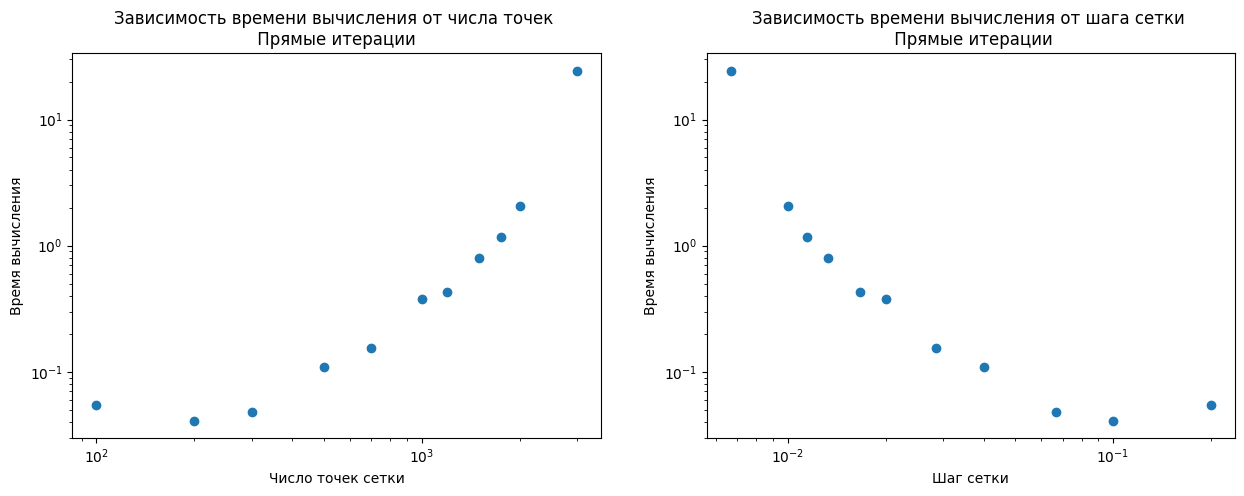

In [33]:
timesLog = np.log10(timeConsumed)
dotsLog = np.log10(numberOfPoints)

print((timesLog[-1] - timesLog[2])/( dotsLog[-1] - dotsLog[2] ))

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(numberOfPoints, timeConsumed)
axes[0].set_xlabel("Число точек сетки")
axes[0].set_ylabel("Время вычисления")
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title("Зависимость времени вычисления от числа точек \n Прямые итерации ")
axes[1].scatter(hs, timeConsumed)
axes[1].set_xlabel("Шаг сетки")
axes[1].set_ylabel("Время вычисления")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title("Зависимость времени вычисления от шага сетки \n Прямые итерации")
plt.savefig(("Time_Taus_Iter.png"), dpi=300, bbox_inches='tight')
plt.show()

